##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 前処理行列を用いた確率的勾配ランジュバン動力学法を使用してディリクレ過程混合モデルを適合する

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/probability/examples/Fitting_DPMM_Using_pSGLD">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Fitting_DPMM_Using_pSGLD.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Fitting_DPMM_Using_pSGLD.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/Fitting_DPMM_Using_pSGLD.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png"> ノートブックをダウンロード</a></td>
</table>

このノートブックでは、ガウス分布のディリクレ過程混合モデルを適合し、大量のサンプルのクラスター化とクラスター数の推論を同時に行う方法を説明します。推論には、前処理行列を用いた確率的勾配ランジュバン動力学法（pSGLD）を使用します。 

## 目次

1. サンプル

2. モデル

3. 最適化

4. 結果を視覚化する

4.1. クラスター化された結果

4.2. 不確実性を視覚化する

4.3. 選択された混合コンポーネントの平均とスケール

4.4. 各混合コンポーネントの混合重み

4.5. $\alpha$ の収束

4.6. イテレーションで推論されるクラスターの数

4.7. RMSProp を使ってモデルを適合する

1. 結論

---


## 1. サンプル

まず、トイデータセットをセットアップします。3 つの二変量ガウス分布から 50,000 個のランダムサンプルを生成します。

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp

In [ ]:
plt.style.use('ggplot')
tfd = tfp.distributions

In [ ]:
def session_options(enable_gpu_ram_resizing=True):
  """Convenience function which sets common `tf.Session` options."""
  config = tf.ConfigProto()
  config.log_device_placement = True
  if enable_gpu_ram_resizing:
    # `allow_growth=True` makes it possible to connect multiple colabs to your
    # GPU. Otherwise the colab malloc's all GPU ram.
    config.gpu_options.allow_growth = True
  return config

def reset_sess(config=None):
  """Convenience function to create the TF graph and session, or reset them."""
  if config is None:
    config = session_options()
  tf.reset_default_graph()
  global sess
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession(config=config)

In [ ]:
# For reproducibility
rng = np.random.RandomState(seed=45)
tf.set_random_seed(76)

# Precision
dtype = np.float64

# Number of training samples
num_samples = 50000

# Ground truth loc values which we will infer later on. The scale is 1.
true_loc = np.array([[-4, -4],
                     [0, 0],
                     [4, 4]], dtype)

true_components_num, dims = true_loc.shape

# Generate training samples from ground truth loc
true_hidden_component = rng.randint(0, true_components_num, num_samples)
observations = (true_loc[true_hidden_component]
                + rng.randn(num_samples, dims).astype(dtype))

In [ ]:
# Visualize samples
plt.scatter(observations[:, 0], observations[:, 1], 1)
plt.axis([-10, 10, -10, 10])
plt.show()

## 2. モデル

ここでは、対称ディレクレ事前分布を使ってガウス分布のディレクレ過程混合を定義します。このノートブックでは、ベクトル量を太字で記述しています。$i\in{1,\ldots,N}$ 個のサンプルに対し、$j \in{1,\ldots,K}$ ガウス分布の混合行列は、次のように計算されます。

$$\begin{align*}
p(\boldsymbol{x}_1,\cdots, \boldsymbol{x}_N) &=\prod_{i=1}^N \text{GMM}(x_i), \\
&\,\quad \text{with}\;\text{GMM}(x_i)=\sum_{j=1}^K\pi_j\text{Normal}(x_i\,|\,\text{loc}=\boldsymbol{\mu_{j}},\,\text{scale}=\boldsymbol{\sigma_{j}})\\ 
\end{align*}$$ where:

$$\begin{align*}
x_i&\sim \text{Normal}(\text{loc}=\boldsymbol{\mu}_{z_i},\,\text{scale}=\boldsymbol{\sigma}_{z_i}) \\
z_i &= \text{Categorical}(\text{prob}=\boldsymbol{\pi}),\\
&\,\quad \text{with}\;\boldsymbol{\pi}=\{\pi_1,\cdots,\pi_K\}\\
\boldsymbol{\pi}&\sim\text{Dirichlet}(\text{concentration}=\{\frac{\alpha}{K},\cdots,\frac{\alpha}{K}\})\\
\alpha&\sim \text{InverseGamma}(\text{concentration}=1,\,\text{rate}=1)\\
\boldsymbol{\mu_j} &\sim \text{Normal}(\text{loc}=\boldsymbol{0}, \,\text{scale}=\boldsymbol{1})\\
\boldsymbol{\sigma_j} &\sim \text{InverseGamma}(\text{concentration}=\boldsymbol{1},\,\text{rate}=\boldsymbol{1})\\
\end{align*}$$

クラスターの推論されたインデックスを表す $z_i$ を通じて、それぞれの $x_i$ を $j$ 番目のクラスターに代入するが目標です。

理想的なディリクレ混合モデルでは $K$ は $\infty$ に設定されますが、$K$ が十分に大きい場合は、ディリクレ混合モデルに近似できることが知られています。$K$ の初期値を任意に設定していますが、単純なガウス混合モデルとは異なり、最適なクラスターの数も最適化によって推論されます。

このノートブックでは、二変量ガウス分布を混合コンポーネントをして使用し、$K$ を 30 に設定します。

In [ ]:
reset_sess()

# Upperbound on K
max_cluster_num = 30

# Define trainable variables.
mix_probs = tf.nn.softmax(
    tf.Variable(
        name='mix_probs',
        initial_value=np.ones([max_cluster_num], dtype) / max_cluster_num))

loc = tf.Variable(
    name='loc',
    initial_value=np.random.uniform(
        low=-9, #set around minimum value of sample value
        high=9, #set around maximum value of sample value
        size=[max_cluster_num, dims]))

precision = tf.nn.softplus(tf.Variable(
    name='precision',
    initial_value=
    np.ones([max_cluster_num, dims], dtype=dtype)))

alpha = tf.nn.softplus(tf.Variable(
    name='alpha',
    initial_value=
    np.ones([1], dtype=dtype)))

training_vals = [mix_probs, alpha, loc, precision]


# Prior distributions of the training variables

#Use symmetric Dirichlet prior as finite approximation of Dirichlet process.
rv_symmetric_dirichlet_process = tfd.Dirichlet(
    concentration=np.ones(max_cluster_num, dtype) * alpha / max_cluster_num,
    name='rv_sdp')

rv_loc = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros([max_cluster_num, dims], dtype=dtype),
        scale=tf.ones([max_cluster_num, dims], dtype=dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_loc')


rv_precision = tfd.Independent(
    tfd.InverseGamma(
        concentration=np.ones([max_cluster_num, dims], dtype),
        rate=np.ones([max_cluster_num, dims], dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_precision')

rv_alpha = tfd.InverseGamma(
    concentration=np.ones([1], dtype=dtype),
    rate=np.ones([1]),
    name='rv_alpha')

# Define mixture model
rv_observations = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix_probs),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=loc,
        scale_diag=precision))

## 3. 最適化


このモデルは、前処理行列を用いた確率的勾配ランジュバン動力学法（pSGLD）で最適化するため、大量のサンプルに対して、モデルをミニバッチの勾配降下法で最適化することができます。

$t,$th 回目のイタレーションにおいてミニバッチサイズ $M$ でパラメータ $\boldsymbol{\theta}\equiv{\boldsymbol{\pi},,\alpha,, \boldsymbol{\mu_j},,\boldsymbol{\sigma_j}}$ を更新するために、更新を次のようにサンプリングします。

$$\begin{align*}
\Delta \boldsymbol { \theta } _ { t } & \sim \frac { \epsilon _ { t } } { 2 } \bigl[ G \left( \boldsymbol { \theta } _ { t } \right) \bigl( \nabla _ { \boldsymbol { \theta } } \log p \left( \boldsymbol { \theta } _ { t } \right) +
 \frac { N } { M } \sum _ { k = 1 } ^ { M } \nabla _ \boldsymbol { \theta } \log \text{GMM}(x_{t_k})\bigr) + \sum_\boldsymbol{\theta}\nabla_\theta G \left( \boldsymbol { \theta } _ { t } \right) \bigr]\\
&+ G ^ { \frac { 1 } { 2 } } \left( \boldsymbol { \theta } _ { t } \right) \text { Normal } \left( \text{loc}=\boldsymbol{0} ,\, \text{scale}=\epsilon _ { t }\boldsymbol{1} \right)\\
\end{align*}$$

上記の方程式では、$\epsilon _ { t }$ は $t,$ 回目のイタレーションの学習率で、$\log p(\theta_t)$ は $\theta$ の対数事前分布の和です。$G ( \boldsymbol { \theta } _ { t })$ は各パラメータの勾配のスケールを調整する前処理行列です。


In [ ]:
# Learning rates and decay
starter_learning_rate = 1e-6
end_learning_rate = 1e-10
decay_steps = 1e4

# Number of training steps
training_steps = 10000

# Mini-batch size
batch_size = 20

# Sample size for parameter posteriors
sample_size = 100

尤度 $\text{GMM}(x_{t_k})$ の同時対数確率と事前確率 $p(\theta_t)$ を pSGLD の損失関数として使用します。

[pSGLD の API](https://www.tensorflow.org/probability/api_docs/python/tfp/optimizer/StochasticGradientLangevinDynamics) に説明されているとおり、事前確率の和をサンプルサイズ $N$ で除算する必要があります。 

In [ ]:
# Placeholder for mini-batch
observations_tensor = tf.compat.v1.placeholder(dtype, shape=[batch_size, dims])

# Define joint log probabilities
# Notice that each prior probability should be divided by num_samples and
# likelihood is divided by batch_size for pSGLD optimization.
log_prob_parts = [
    rv_loc.log_prob(loc) / num_samples,
    rv_precision.log_prob(precision) / num_samples,
    rv_alpha.log_prob(alpha) / num_samples,
    rv_symmetric_dirichlet_process.log_prob(mix_probs)[..., tf.newaxis]
    / num_samples,
    rv_observations.log_prob(observations_tensor) / batch_size
]
joint_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1)

In [ ]:
# Make mini-batch generator
dx = tf.compat.v1.data.Dataset.from_tensor_slices(observations)\
  .shuffle(500).repeat().batch(batch_size)
iterator = tf.compat.v1.data.make_one_shot_iterator(dx)
next_batch = iterator.get_next()

# Define learning rate scheduling
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.polynomial_decay(
    starter_learning_rate,
    global_step, decay_steps,
    end_learning_rate, power=1.)

# Set up the optimizer. Don't forget to set data_size=num_samples.
optimizer_kernel = tfp.optimizer.StochasticGradientLangevinDynamics(
    learning_rate=learning_rate,
    preconditioner_decay_rate=0.99,
    burnin=1500,
    data_size=num_samples)

train_op = optimizer_kernel.minimize(-joint_log_prob)

# Arrays to store samples
mean_mix_probs_mtx = np.zeros([training_steps, max_cluster_num])
mean_alpha_mtx = np.zeros([training_steps, 1])
mean_loc_mtx = np.zeros([training_steps, max_cluster_num, dims])
mean_precision_mtx = np.zeros([training_steps, max_cluster_num, dims])

init = tf.global_variables_initializer()
sess.run(init)

start = time.time()
for it in range(training_steps):
  [
      mean_mix_probs_mtx[it, :],
      mean_alpha_mtx[it, 0],
      mean_loc_mtx[it, :, :],
      mean_precision_mtx[it, :, :],
      _
  ] = sess.run([
      *training_vals,
      train_op
  ], feed_dict={
      observations_tensor: sess.run(next_batch)})

elapsed_time_psgld = time.time() - start
print("Elapsed time: {} seconds".format(elapsed_time_psgld))

# Take mean over the last sample_size iterations
mean_mix_probs_ = mean_mix_probs_mtx[-sample_size:, :].mean(axis=0)
mean_alpha_ = mean_alpha_mtx[-sample_size:, :].mean(axis=0)
mean_loc_ = mean_loc_mtx[-sample_size:, :].mean(axis=0)
mean_precision_ = mean_precision_mtx[-sample_size:, :].mean(axis=0)

Elapsed time: 309.8013095855713 seconds


## 4. 結果を視覚化する

### 4.1. クラスター化された結果

まず、クラスター化の結果を視覚化します。

各サンプル $x_i$ をクラスター $j$ に代入するには、$z_i$ の事後分布を次のように計算します。

$$\begin{align*}
j =  \underset{z_i}{\arg\max}\,p(z_i\,|\,x_i,\,\boldsymbol{\theta})
\end{align*}$$

In [ ]:
loc_for_posterior = tf.compat.v1.placeholder(
    dtype, [None, max_cluster_num, dims], name='loc_for_posterior')
precision_for_posterior = tf.compat.v1.placeholder(
    dtype, [None, max_cluster_num, dims], name='precision_for_posterior')
mix_probs_for_posterior = tf.compat.v1.placeholder(
    dtype, [None, max_cluster_num], name='mix_probs_for_posterior')

# Posterior of z (unnormalized)
unnomarlized_posterior = tfd.MultivariateNormalDiag(
    loc=loc_for_posterior, scale_diag=precision_for_posterior)\
   .log_prob(tf.expand_dims(tf.expand_dims(observations, axis=1), axis=1))\
   + tf.log(mix_probs_for_posterior[tf.newaxis, ...])

# Posterior of z (normarizad over latent states)
posterior = unnomarlized_posterior\
  - tf.reduce_logsumexp(unnomarlized_posterior, axis=-1)[..., tf.newaxis]

cluster_asgmt = sess.run(tf.argmax(
    tf.reduce_mean(posterior, axis=1), axis=1), feed_dict={
        loc_for_posterior: mean_loc_mtx[-sample_size:, :],
        precision_for_posterior: mean_precision_mtx[-sample_size:, :],
        mix_probs_for_posterior: mean_mix_probs_mtx[-sample_size:, :]})

idxs, count = np.unique(cluster_asgmt, return_counts=True)

print('Number of inferred clusters = {}\n'.format(len(count)))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Number of elements in each cluster = {}\n'.format(count))

def convert_int_elements_to_consecutive_numbers_in(array):
  unique_int_elements = np.unique(array)
  for consecutive_number, unique_int_element in enumerate(unique_int_elements):
    array[array == unique_int_element] = consecutive_number
  return array

cmap = plt.get_cmap('tab10')
plt.scatter(
    observations[:, 0], observations[:, 1],
    1,
    c=cmap(convert_int_elements_to_consecutive_numbers_in(cluster_asgmt)))
plt.axis([-10, 10, -10, 10])
plt.show()

Number of inferred clusters = 3

Number of elements in each cluster = [16911 16645 16444]



ほぼ同数のサンプルが適切なクラスターに代入され、モデルが正しい数のクラスターを推論できたことが確認できます。


### 4.2. 不確実性を視覚化する

次に、サンプルごとにクラスター化の結果の不確実性を視覚化して確認します。

不確実性は、次のようにエントロピーを使用して計算します。

$$\begin{align*}
\text{Uncertainty}_\text{entropy} =  -\frac{1}{K}\sum^{K}_{z_i=1}\sum^{O}_{l=1}p(z_i\,|\,x_i,\,\boldsymbol{\theta}_l)\log p(z_i\,|\,x_i,\,\boldsymbol{\theta}_l)
\end{align*}$$

pSGLD では、イタレーションごとのトレーニングパラメータの値をその事後分布のサンプルとして処理します。したがって、パラメータごとに $O$ イタレーションの値に対するエントロピーを計算します。最終的なエントロピー値は、全クラスター代入のエントロピーを平均化して計算されます。

In [ ]:
# Calculate entropy
posterior_in_exponential = tf.exp(posterior)
uncertainty_in_entropy = tf.reduce_mean(-tf.reduce_sum(
    posterior_in_exponential
    * posterior,
    axis=1), axis=1)

uncertainty_in_entropy_ = sess.run(uncertainty_in_entropy, feed_dict={
    loc_for_posterior: mean_loc_mtx[-sample_size:, :],
    precision_for_posterior: mean_precision_mtx[-sample_size:, :],
    mix_probs_for_posterior: mean_mix_probs_mtx[-sample_size:, :]
})

In [ ]:
plt.title('Entropy')
sc = plt.scatter(observations[:, 0],
                 observations[:, 1],
                 1,
                 c=uncertainty_in_entropy_,
                 cmap=plt.cm.viridis_r)
cbar = plt.colorbar(sc,
                    fraction=0.046,
                    pad=0.04,
                    ticks=[uncertainty_in_entropy_.min(),
                           uncertainty_in_entropy_.max()])
cbar.ax.set_yticklabels(['low', 'high'])
cbar.set_label('Uncertainty', rotation=270)
plt.show()

上記のグラフでは、輝度が低いほど不確実性が高いことを示します。クラスターの境界近くのサンプルの不確実性が特に高いことがわかります。直感的に、これらのサンプルをクラスター化するのが困難であることを知ることができます。

### 4.3. 選択された混合コンポーネントの平均とスケール

次に、選択されたクラスターの $\mu_j$ と $\sigma_j$ を見てみましょう。

In [ ]:
for idx, numbe_of_samples in zip(idxs, count):
  print(
      'Component id = {}, Number of elements = {}'
      .format(idx, numbe_of_samples))
  print(
      'Mean loc = {}, Mean scale = {}\n'
      .format(mean_loc_[idx, :], mean_precision_[idx, :]))

Component id = 0, Number of elements = 16911
Mean loc = [-4.030 -4.113], Mean scale = [ 0.994  0.972]

Component id = 4, Number of elements = 16645
Mean loc = [ 3.999  4.069], Mean scale = [ 1.038  1.046]

Component id = 5, Number of elements = 16444
Mean loc = [-0.005 -0.023], Mean scale = [ 0.967  1.025]



またしても、$\boldsymbol{\mu_j}$ と $\boldsymbol{\sigma_j}$ は、グラウンドトゥルースに近い結果が得られています。

### 4.4 各混合コンポーネントの混合重み

推論された混合重みも確認しましょう。

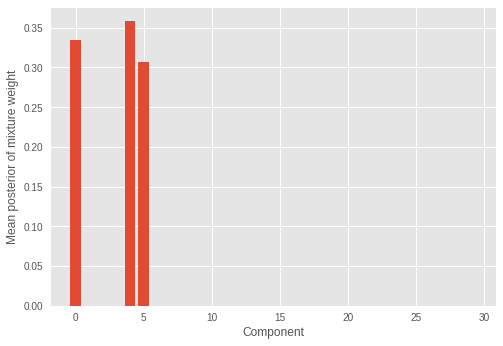

In [ ]:
plt.ylabel('Mean posterior of mixture weight')
plt.xlabel('Component')
plt.bar(range(0, max_cluster_num), mean_mix_probs_)
plt.show()

いくつか（3 つ）の混合コンポーネントにのみ大きな重みがあり、残りはゼロに近い値となっているのがわかります。これはまた、モデルがサンプルの分布を構成する正しい数の混合コンポーネントを推論したことも示しています。

### 4.5. $\alpha$ の収束

ディリクレ分布の集中度パラメータ $\alpha$ の収束を調べましょう。

Value of inferred alpha = 0.679



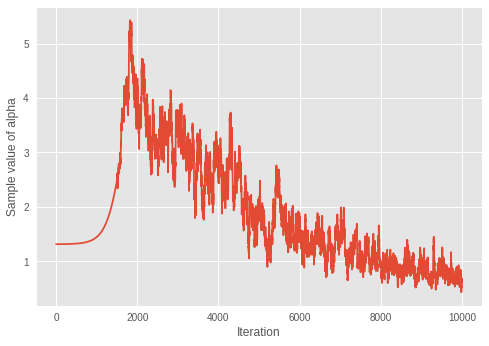

In [ ]:
print('Value of inferred alpha = {0:.3f}\n'.format(mean_alpha_[0]))
plt.ylabel('Sample value of alpha')
plt.xlabel('Iteration')
plt.plot(mean_alpha_mtx)
plt.show()

ディリクレ混合モデルでは $\alpha$ が小さいほど期待されるクラスター数が低くなることを考慮すると、モデルはイタレーションごとに最適な数のクラスターを学習しているようです。

### 4.6. イテレーションで推論されるクラスターの数

推論されるクラスター数が、イテレーションを通じてどのように変化するかを視覚化します。

これを行うには、インテレーションでのクラスター数を推論します。

In [ ]:
step = sample_size
num_of_iterations = 50
estimated_num_of_clusters = []
interval = (training_steps - step) // (num_of_iterations - 1)
iterations = np.asarray(range(step, training_steps+1, interval))
for iteration in iterations:
  start_position = iteration-step
  end_position = iteration

  result = sess.run(tf.argmax(
      tf.reduce_mean(posterior, axis=1), axis=1), feed_dict={
          loc_for_posterior:
              mean_loc_mtx[start_position:end_position, :],
          precision_for_posterior:
              mean_precision_mtx[start_position:end_position, :],
          mix_probs_for_posterior:
              mean_mix_probs_mtx[start_position:end_position, :]})

  idxs, count = np.unique(result, return_counts=True)
  estimated_num_of_clusters.append(len(count))

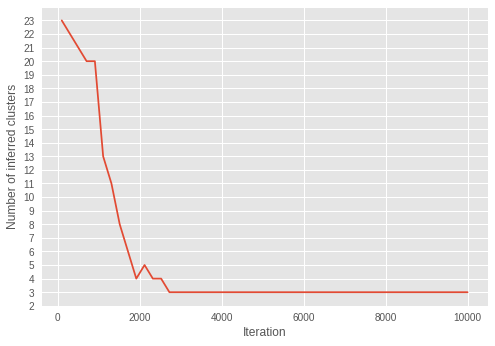

In [ ]:
plt.ylabel('Number of inferred clusters')
plt.xlabel('Iteration')
plt.yticks(np.arange(1, max(estimated_num_of_clusters) + 1, 1))
plt.plot(iterations - 1, estimated_num_of_clusters)
plt.show()

インテレーションを繰り返すと、クラスターの数が 3 に近づいていきます。イテレーションを繰り返すうちに、$\alpha$ がより小さな値に収束することから、モデルが最適なクラスターの数を推論するようにパラメータを正しく学習していることがわかります。

興味深いことに、ずっと後のイテレーションで収束した $\alpha$ とは異なり、早期のイテレーションで推論がすでに適切なクラスター数に収束していることが示されています。


### 4.7. RMSProp を使ってモデルを適合する 

このセクションでは、pSGLD のモンテカルロサンプリングスキームの有効性を確認するために、RMSProp を使用してモデルを適合します。RMSProp にはサンプリングスキームがなく、pSGLD はF RMSProp に基づいているため、比較のために RMSProp を選んでいます。


In [ ]:
# Learning rates and decay
starter_learning_rate_rmsprop = 1e-2
end_learning_rate_rmsprop = 1e-4
decay_steps_rmsprop = 1e4

# Number of training steps
training_steps_rmsprop = 50000

# Mini-batch size
batch_size_rmsprop = 20

In [ ]:
# Define trainable variables.
mix_probs_rmsprop = tf.nn.softmax(
    tf.Variable(
        name='mix_probs_rmsprop',
        initial_value=np.ones([max_cluster_num], dtype) / max_cluster_num))

loc_rmsprop = tf.Variable(
    name='loc_rmsprop',
    initial_value=np.zeros([max_cluster_num, dims], dtype)
    + np.random.uniform(
        low=-9, #set around minimum value of sample value
        high=9, #set around maximum value of sample value
        size=[max_cluster_num, dims]))

precision_rmsprop = tf.nn.softplus(tf.Variable(
    name='precision_rmsprop',
    initial_value=
    np.ones([max_cluster_num, dims], dtype=dtype)))

alpha_rmsprop = tf.nn.softplus(tf.Variable(
    name='alpha_rmsprop',
    initial_value=
    np.ones([1], dtype=dtype)))

training_vals_rmsprop =\
    [mix_probs_rmsprop, alpha_rmsprop, loc_rmsprop, precision_rmsprop]

# Prior distributions of the training variables

#Use symmetric Dirichlet prior as finite approximation of Dirichlet process.
rv_symmetric_dirichlet_process_rmsprop = tfd.Dirichlet(
    concentration=np.ones(max_cluster_num, dtype)
    * alpha_rmsprop / max_cluster_num,
    name='rv_sdp_rmsprop')

rv_loc_rmsprop = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros([max_cluster_num, dims], dtype=dtype),
        scale=tf.ones([max_cluster_num, dims], dtype=dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_loc_rmsprop')


rv_precision_rmsprop = tfd.Independent(
    tfd.InverseGamma(
        concentration=np.ones([max_cluster_num, dims], dtype),
        rate=np.ones([max_cluster_num, dims], dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_precision_rmsprop')

rv_alpha_rmsprop = tfd.InverseGamma(
    concentration=np.ones([1], dtype=dtype),
    rate=np.ones([1]),
    name='rv_alpha_rmsprop')

# Define mixture model
rv_observations_rmsprop = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix_probs_rmsprop),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=loc_rmsprop,
        scale_diag=precision_rmsprop))

In [ ]:
og_prob_parts_rmsprop = [
    rv_loc_rmsprop.log_prob(loc_rmsprop),
    rv_precision_rmsprop.log_prob(precision_rmsprop),
    rv_alpha_rmsprop.log_prob(alpha_rmsprop),
    rv_symmetric_dirichlet_process_rmsprop
        .log_prob(mix_probs_rmsprop)[..., tf.newaxis],
    rv_observations_rmsprop.log_prob(observations_tensor)
    * num_samples / batch_size
]
joint_log_prob_rmsprop = tf.reduce_sum(
    tf.concat(log_prob_parts_rmsprop, axis=-1), axis=-1)

In [ ]:
# Define learning rate scheduling
global_step_rmsprop = tf.Variable(0, trainable=False)
learning_rate = tf.train.polynomial_decay(
    starter_learning_rate_rmsprop,
    global_step_rmsprop, decay_steps_rmsprop,
    end_learning_rate_rmsprop, power=1.)

# Set up the optimizer. Don't forget to set data_size=num_samples.
optimizer_kernel_rmsprop = tf.train.RMSPropOptimizer(
    learning_rate=learning_rate,
    decay=0.99)

train_op_rmsprop = optimizer_kernel_rmsprop.minimize(-joint_log_prob_rmsprop)

init_rmsprop = tf.global_variables_initializer()
sess.run(init_rmsprop)

start = time.time()
for it in range(training_steps_rmsprop):
  [
      _
  ] = sess.run([
      train_op_rmsprop
  ], feed_dict={
      observations_tensor: sess.run(next_batch)})

elapsed_time_rmsprop = time.time() - start
print("RMSProp elapsed_time: {} seconds ({} iterations)"
      .format(elapsed_time_rmsprop, training_steps_rmsprop))
print("pSGLD elapsed_time: {} seconds ({} iterations)"
      .format(elapsed_time_psgld, training_steps))

mix_probs_rmsprop_, alpha_rmsprop_, loc_rmsprop_, precision_rmsprop_ =\
  sess.run(training_vals_rmsprop)

RMSProp elapsed_time: 53.7574200630188 seconds (50000 iterations)
pSGLD elapsed_time: 309.8013095855713 seconds (10000 iterations)


pSGLD に比較して、RMSProp のイテレーション数の方が長いにも関わらず、RMSProp による最適化の方がはるかに高速に行われています。

次に、クラスター化の結果を確認しましょう。

In [ ]:
cluster_asgmt_rmsprop = sess.run(tf.argmax(
    tf.reduce_mean(posterior, axis=1), axis=1), feed_dict={
        loc_for_posterior: loc_rmsprop_[tf.newaxis, :],
        precision_for_posterior: precision_rmsprop_[tf.newaxis, :],
        mix_probs_for_posterior: mix_probs_rmsprop_[tf.newaxis, :]})

idxs, count = np.unique(cluster_asgmt_rmsprop, return_counts=True)

print('Number of inferred clusters = {}\n'.format(len(count)))
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

print('Number of elements in each cluster = {}\n'.format(count))

cmap = plt.get_cmap('tab10')
plt.scatter(
    observations[:, 0], observations[:, 1],
    1,
    c=cmap(convert_int_elements_to_consecutive_numbers_in(
        cluster_asgmt_rmsprop)))
plt.axis([-10, 10, -10, 10])
plt.show()

Number of inferred clusters = 4

Number of elements in each cluster = [ 1644 15267 16647 16442]



この実験では、RMSProp によって正しいクラスター数を推論することができませんでした。混合重みも見てみましょう。

In [ ]:
plt.ylabel('MAP inferece of mixture weight')
plt.xlabel('Component')
plt.bar(range(0, max_cluster_num), mix_probs_rmsprop_)
plt.show()

誤ったコンポーネント数に著しい混合重みがあるのがわかります。

最適化には時間が掛かりますが、モンテカルロサンプリングスキームを持つ pSGLD は、この実験よりもよりうまく動作しています。

## 5. 結論

このノートブックでは、大量のサンプルをクラスター化し、pSGLD を使用してガウス分布のディリクレ過程混合モデルを適合することで、同時にクラスターの数を推論する方法を説明しました。

この実験では、モデルが正しくサンプルをクラスター化し、正しいクラスター数を推論したことが示されました。また、pSGLD のモンテカルロサンプリングスキームによって、結果の不確実性を視覚化できることも説明しました。サンプルをクラスター化するだけでなく、モデルが混合コンポーネントの正しいパラメータを推論できることを目の当たりにしました。パラメータと推論されたクラスター数の関係については、𝛼 の収束と推論されたクラスターの数の相関関係を視覚化することによって、モデルがどのようにパラメータを学習して有効なクラスターの数を制御するのかを調べました。最後に、RMSProp を使用してモデルの適合の結果を確認しました。モンテカルロサンプリングスキームをもたないオプティマイザである RMSProp は pSGLD よりもはるかに高速に動作する一方で、クラスター化の精度に劣ることがわかりました。

トイデータセットには、2 次元の 50,000 サンプルしかありませんでしたが、ここで使用したミニバッチ手法の最適化によって、はるかに大きなデータセットにスケーリングされています。